In [4]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

LOCAL = False
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"
import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [5]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

In [8]:
if "fasta" not in list(config[section]):  # write files to config

    MPRA = os.path.join(PATH, "delta_rank.csv")

    FASTA = os.path.join(PATH, "library_2", "Design",
                         "biomarin-lib2-hg38-final.fasta")
    META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")


    DELTA_ACTIVITY = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    DELTA_ACTIVITY_Z = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
    SIG_ACTIVITY_Z = os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")
    VISTA = os.path.join(PATH, "vista.lib2.tiles.bed")

    # delta MPRA activity
    config[section]["delta.mpra_richa"] = MPRA
    config[section]["delta.mpra_centered"] = DELTA_ACTIVITY
    config[section]["delta.mpra_centeredz"] = DELTA_ACTIVITY_Z

    config[section]["fasta"] = FASTA

    # genome coordinates
    config[section]["tile_bed"] = TILE_BED
    config[section]["enh_bed"] = ENH_BED

    # GREAT
    config[section]["great_nearest"] = GREAT_GENE_TSV

    # meta_data
    config[section]["metadata"] = META_DATA

    # significance GABA v. GLUT
    config[section]["sig-wilcoxon"] = SIG_ACTIVITY_Z

    # vista
    config[section]["vista"] = VISTA
    crw.write(config, cfn)

else:
    MPRA = config[section]["delta.mpra_richa"]
    DELTA_ACTIVITY = config[section]["delta.mpra_centered"]
    DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

    FASTA = config[section]["fasta"]

    TILE_BED = config[section]["tile_bed"]
    ENH_BED = config[section]["enh_bed"]

    GREAT_GENE_TSV = config[section]["great_nearest"]
    META_DATA = config[section]["metadata"]

    SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]
    VISTA = config[section]["vista"]

In [9]:
meta = pd.read_csv(META_DATA, sep='\t')
delta = pd.read_csv(DELTA_ACTIVITY_Z, sep='\t')

len(set(meta["enh.id"]))

1828

In [10]:
delta.shape

(35371, 10)

# load MPRA data

In [11]:
mpra = pd.read_csv(MPRA)

mpra

,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0
...,...,...,...,...,...
35366,chr9:127613026-127613296,0.758066,-0.412615,1.170681,35367.0
35367,chr10:97633041-97633311,0.727817,-0.488544,1.216361,35368.0
35368,chr10:32056179-32056449,0.861082,-0.358334,1.219416,35369.0
35369,chr10:97633021-97633291,0.614040,-0.609305,1.223346,35370.0


## filter to keep only synthetics

In [16]:
mpra=mpra.loc[mpra["name"].str.contains("seq")]

In [17]:
print(mpra.shape)
mpra.head()

(968, 5)


,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
7,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.754227,-0.005828,-1.748399,8.0
8,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.581979,0.136294,-1.718273,9.0
12,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.807870,-0.113684,-1.694187,13.0
16,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.809980,-0.147642,-1.662338,17.0
17,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.470171,0.191895,-1.662066,18.0


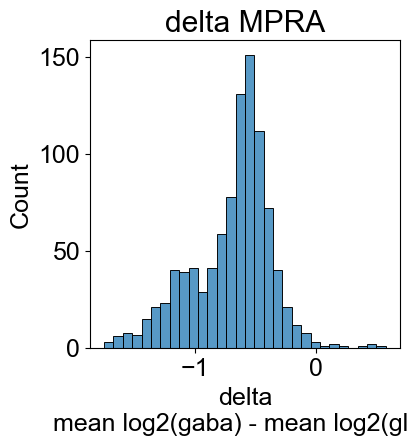

In [19]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(mpra["delta"])
ax.set(title="delta MPRA",
      xlabel="delta\nmean log2(gaba) - mean log2(glut)")
plt.savefig(os.path.join(RE, "deltas.syn.pdf"), bbox_inches="tight")

In [20]:
mpra["delta"].describe()

count    968.000000
mean      -0.694709
std        0.331497
min       -1.748399
25%       -0.877441
50%       -0.617139
75%       -0.488991
max        0.576515
Name: delta, dtype: float64

In [21]:
set(meta["bkgd"])

{False, True}

In [22]:
meta.shape

(44044, 15)

# add GREAT annotations to fasta meta data

In [24]:
enh = meta.loc[meta["bkgd"]==True]

# rename columns for merging with MPRA data
enh = enh.rename(columns ={"start":"start.tile",
                           "end":"end.tile"})

print(enh.shape)
enh.head()

(1296, 15)


,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,start.tile,end.tile,enh.id,enh.name,tile.order
3791,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,627.0
3792,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,603.0
3793,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,579.0
3794,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,555.0
3795,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,629.0


# add MPRA

In [25]:
enh = pd.merge(enh, mpra, how="left", left_on="name",
               right_on="name").drop_duplicates()
print(enh.shape)
enh.head()

(1296, 19)


,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,start.tile,end.tile,enh.id,enh.name,tile.order,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,627.0,-1.527215,-0.690321,-0.836894,1646.0
1,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,603.0,-1.283744,-0.738124,-0.545619,4857.0
2,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,579.0,-1.591621,-0.832101,-0.759520,2236.0
3,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,555.0,NaN,NaN,NaN,NaN
4,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,629.0,-1.456528,-0.845583,-0.610945,3856.0


In [26]:
enh = pd.merge(enh, delta, how="left", left_on ="name", right_on="name").drop_duplicates()

enh.shape

(1296, 28)

# add significance data

In [28]:
sig_reps= pd.read_csv(SIG_ACTIVITY_Z, sep='\t')
print(sig_reps.shape)
sig_reps.head()

(35371, 11)


,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.037107,False,0.119390,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,False,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,False,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,False,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,False,0.801537,0.096076


In [41]:
sig_reps.loc[sig_reps["name"].isin(enh['name'])].groupby(["fdr_bool"])["name"].count()

fdr_bool
False    945
True      23
Name: name, dtype: int64

## example of significant, non-significant reps

In [31]:
sig_reps.sample(n=3)

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
12595,chr19:38683388-38683658,-0.331170,-0.318816,-0.526820,0.206726,-0.166254,-0.353077,0.215353,False,0.338666,0.470228
13122,chr19:57614522-57614792,0.793339,0.222935,0.188583,-0.543947,0.602737,0.390731,0.574851,False,0.679865,0.167577
26139,chr5:132865985-132866255,-0.090345,0.201754,0.096167,-0.364075,-0.711829,-0.110003,0.099372,False,0.203918,0.690545


In [30]:
enh= pd.merge(enh, sig_reps, how="left").drop_duplicates()
enh["sig"] = enh["fdr"].apply(lambda x: True if x<0.05 else False)

enh["gaba"] = enh[["gaba_1", "gaba_2", "gaba_3"]].mean(axis=1)

enh["glut"] = enh[["glut_1", "glut_2", "glut_3"]].mean(axis=1)
enh["delta.gaba-glut"] = enh["gaba"]-enh["glut"]

enh.head()

,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,...,fdr,-log10p_fdr,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool
0,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.173911,0.759672,-2.421393,-2.184369,-2.227760,-1.956195,-1.840061,-1.376951,0.072685,False
1,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.817770,0.087369,-2.019538,-1.677746,-2.074945,-2.181752,-1.903716,-1.406938,0.741336,False
2,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.061749,1.209370,-2.352699,-2.466286,-2.295281,-2.131924,-1.977559,-2.010440,0.008621,False
3,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,0.591141,0.228309,-2.211512,-1.975496,-2.338388,-2.062864,-1.947051,-2.200030,0.466315,False


## plot sig deltas

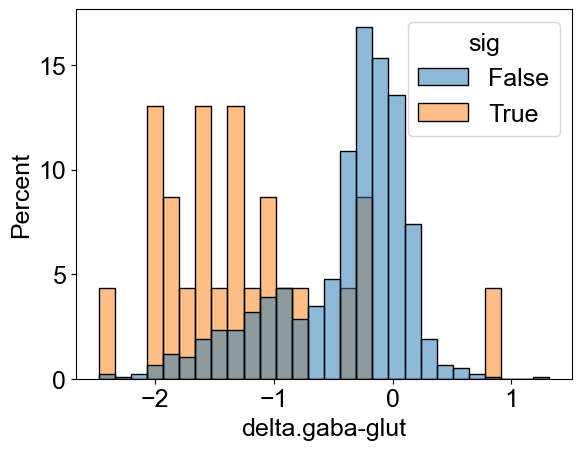

In [31]:
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig", stat="percent", common_norm=False)
out = os.path.join(RE, "delta.dist.syn.sig.only.pdf")
plt.savefig(out, bbox_inches='tight')

## combine significant ttest and celltype_dif (categorical) labels

In [34]:
enh = enh.loc[~enh["fdr"].isna()]

In [35]:
enh["sig_n_dif"] = False
#enh.loc[(enh["sig"]==True) & (enh["celltype_dif"]==True), "sig_n_dif"]=True
enh.loc[(enh["fdr_bool"]==True) & (enh["celltype_dif"]==True), "sig_n_dif"]=True

# print counts
print(enh[["name", "sig"]].drop_duplicates().groupby("sig")['name'].count())
print(enh[["name", "celltype_dif"]].drop_duplicates().groupby("celltype_dif")['name'].count())
print(enh[["name", "sig_n_dif"]].drop_duplicates().groupby("sig_n_dif")['name'].count())

sig
False    945
True      23
Name: name, dtype: int64
celltype_dif
False    835
True     133
Name: name, dtype: int64
sig_n_dif
False    964
True       4
Name: name, dtype: int64


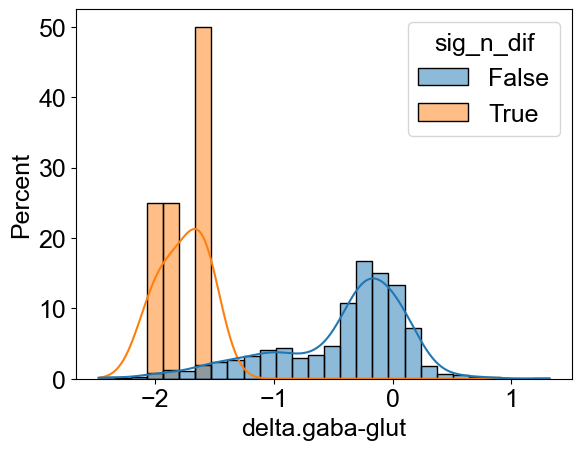

In [36]:
# histogram sig_n_dif
sns.histplot(x="delta.gaba-glut", data=enh, hue="sig_n_dif", kde=True, stat="percent", common_norm=False)
out = os.path.join(RE,"delta.distribution.sig_n_dif.syn.pdf")
plt.savefig(out, bbox_inches='tight')

In [37]:
4/964

0.004149377593360996

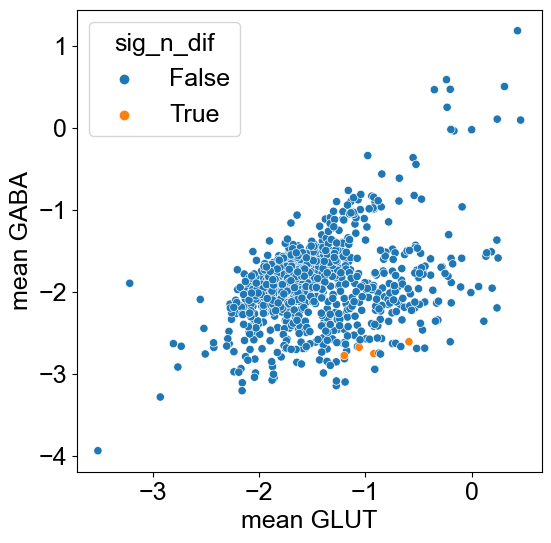

In [42]:
# effect sizes of sig and dif
fig, ax= plt.subplots(figsize=(6,6))
y="gaba" 
x="glut" 
data=enh 
hue="sig_n_dif"
sns.scatterplot(x=x, y=y, data=data, hue=hue)
out = os.path.join(RE, "cell-type-dif.scatter.syn.pdf")
ax.set(xlabel="mean GLUT", 
      ylabel="mean GABA")
plt.savefig(out, bbox_inches='tight')

## bootstrap effect size from full distribution
- generate if not written to config already

In [43]:
if "bsdelta.n" not in list(config[section]):

    # set up and bootstrap delta effect sizes
    BS = 1000
    bs_results975, bs_results025 = [], []
    
    for i in np.arange(BS):

        # bootstrap from entire MPRA distribution
        bsdf = enh[["coor", "gaba", "glut", "delta.gaba-glut"]
                   ].drop_duplicates().copy()
        
        # sample delta scores with replacement
        sample = bsdf["delta.gaba-glut"].sample(n=bsdf.shape[0], replace=True)

        # bootstrap 95% confidence intervals
        bs_results975.append(sample.quantile(0.975))
        bs_results025.append(sample.quantile(0.025))

    BS975_MED, BS025_MED= np.median(bs_results975), np.median(bs_results025)

    # write results to config
    config[section]["bsdelta.n"]= str(BS)
    config[section]["bs975.delta.1000.median"] = str(BS975_MED)
    config[section]["bs025.delta.1000.median"] = str(BS025_MED)
    crw.write(config, cfn)

else: # pull from config
    BS975_MED =  float(config[section]["bs975.delta.1000.median"])
    BS025_MED =  float(config[section]["bs025.delta.1000.median"])
    BS = int(config[section]["bsdelta.n"])

# print boostrated confidence intervals    
print("bootstrapped median 97.5% and 2.5% ci's",
      BS975_MED, BS025_MED, BS)

bootstrapped median 97.5% and 2.5% ci's 1.160405260558053 -1.6148481368655734 1000


### write bootstrap to config 

### keep only delta values more extreme than bootstrapped delta distribution

In [44]:
# annotate enhancer tiles that surpass the CI
enh["bs"] = enh['delta.gaba-glut'].apply(lambda x: True if x >  BS975_MED or x < BS025_MED else False)

### plot bs values w full effectsize distribution

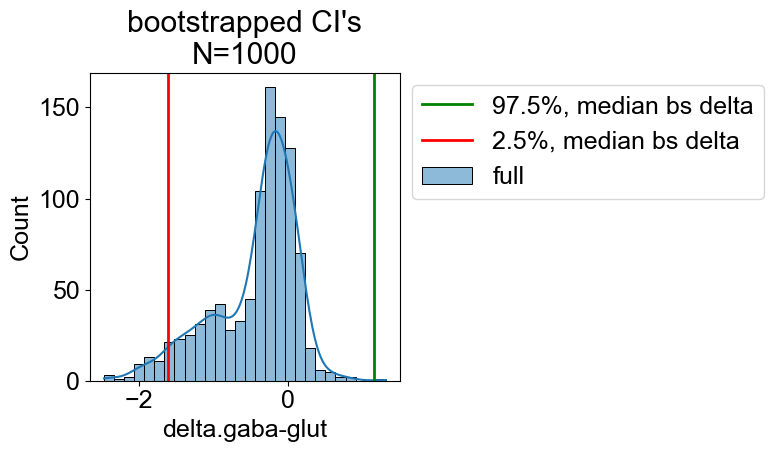

In [46]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot delta distribution
sns.histplot(enh["delta.gaba-glut"], label=f"full", kde=True)


# plot BS CIs
ax.axvline(BS975_MED,
           label=f"97.5%, median bs delta", color="green", lw=2)
ax.axvline(BS025_MED,
           label=f"2.5%, median bs delta", color="red", lw=2)

# get rid of legend
ax.legend(bbox_to_anchor=(1,1))

# set labels
ax.set(xlabel="delta.gaba-glut", title=f"bootstrapped CI's\nN={BS}")

# save
out = os.path.join(RE, "bs-deltas.syn.pdf")
plt.savefig(out, bbox_inches='tight')

### plot bs values with only significant and difference elements

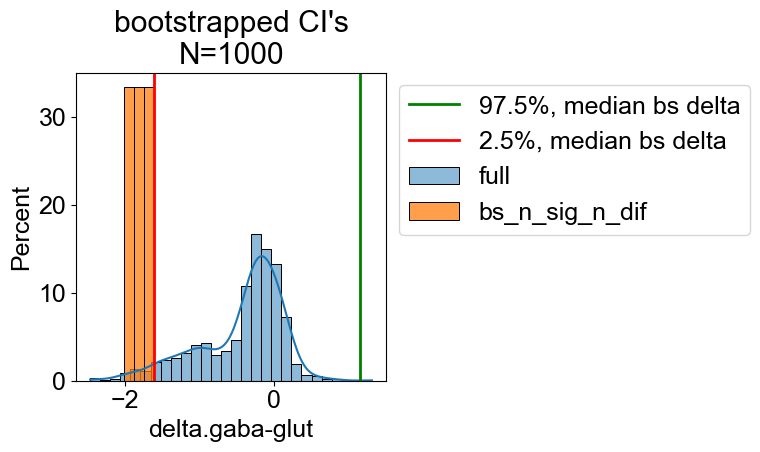

In [47]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot delta distribution
sns.histplot(enh["delta.gaba-glut"], label=f"full", stat="percent", kde=True)
sns.histplot(enh.loc[(enh["sig_n_dif"] == True) &
                     (enh["bs"] == True),
                     "delta.gaba-glut"],
             label=f"bs_n_sig_n_dif",
             stat="percent", kde=False
             )

# plot BS CIs
ax.axvline(BS975_MED,
           label=f"97.5%, median bs delta", color="green", lw=2)
ax.axvline(BS025_MED,
           label=f"2.5%, median bs delta", color="red", lw=2)

# get rid of legend
ax.legend(bbox_to_anchor=(1,1))

# set labels
ax.set(xlabel="delta.gaba-glut", title=f"bootstrapped CI's\nN={BS}")

# save
out = os.path.join(RE, "bs-deltas.bs_n_sig_n_dif.syn.pdf")
plt.savefig(out, bbox_inches='tight')

## add direction to  delta values

In [48]:
def responseDirection(df):
    col = "direction"
    df[col] = None
    inspection_cols = [col,
                       'delta.gaba-glut',
                       "gaba",
                       "glut",
                       'gaba_1',
                       'gaba_2',
                       'gaba_3',
                       'glut_1',
                       'glut_2',
                       'glut_3']

    df.loc[(df['gaba'] < 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "both negative, GABA<GLUT"  # GABA is more silencing than glut

    df.loc[(df['gaba'] < 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "both negative, GLUT<GABA"  # GLUT is more silencing than GABA

    df.loc[(df['gaba'] > 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "both positive GLUT>GABA"  # GLUT is more active than GABA

    df.loc[(df['gaba'] > 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "both positive GABA>GLUT"  # GABA is more active than GLUT

    df.loc[(df['gaba'] < 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "positive GLUT>negative GABA"  # GLUT is active, GABA is not

    df.loc[(df['gaba'] > 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "positive GABA>negative GLUT"  # GABA is active, glut is not.

    print("unlabeled", df.loc[df[col].isna(), inspection_cols].shape[0])

    return df.drop_duplicates()

In [49]:
# add direction annotations based on sign of mean GABA, GLUT activity value
enh = responseDirection(enh)

unlabeled 0


In [50]:
#set(enh.loc[enh["direction"].isna()==True, "name"])

enh.loc[enh["name"] == "chr17:43530167-43530437"]

enh.loc[enh["name"].str.contains("Background")]

,name,sequence,bkgd,72h,ctrl,cl,coor,top_bottom,strand,#chr,...,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,sig_n_dif,bs,direction
0,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,-2.184369,-2.227760,-1.956195,-1.840061,-1.376951,0.072685,False,False,False,"both negative, GABA<GLUT"
1,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,-1.677746,-2.074945,-2.181752,-1.903716,-1.406938,0.741336,False,False,False,"both negative, GABA<GLUT"
2,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,-2.466286,-2.295281,-2.131924,-1.977559,-2.010440,0.008621,False,False,False,"both negative, GABA<GLUT"
4,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,-1.975496,-2.338388,-2.062864,-1.947051,-2.200030,0.466315,False,False,False,"both negative, GABA<GLUT"
5,Backgroundseq2chr1:244100624-244100893:+|Pos:1...,AGGACCGGATCAACTGGGAAGCGTTTTTATTCAATCTGATACCCTC...,True,NaN,NaN,NaN,chr1:244100624-244100893,NaN,+,chr1,...,-2.025084,-1.661753,-1.494240,-1.735514,-1.415115,0.086300,False,False,False,"both negative, GABA<GLUT"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,chr::-1--1,top,+,chr:,...,-2.427646,-2.435104,-1.109326,-1.546149,-2.269267,0.166434,False,False,False,"both negative, GABA<GLUT"
1291,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,chr::-1--1,top,+,chr:,...,-2.815486,-2.082078,-0.701322,-1.375914,-2.150103,0.074981,False,False,False,"both negative, GABA<GLUT"
1292,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,chr::-1--1,top,+,chr:,...,-3.315267,-1.975987,-1.770023,-1.867901,-1.843902,0.148265,False,False,False,"both negative, GABA<GLUT"
1294,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",AGGACCGGATCAACTCTACTCCTGTGCGGGGTTAAGACCTAAGGAA...,True,NaN,NaN,NaN,chr::-1--1,top,+,chr:,...,-2.658716,-2.248103,-2.620825,-1.618896,-2.191807,0.491651,False,False,False,"both negative, GABA<GLUT"


In [51]:
enh["sig_n_dif_n_bs"] = False
enh.loc[(enh["sig_n_dif"]==True) & (enh["bs"]==True), "sig_n_dif_n_bs"] = True

cols = ["bs", 'sig',
        'direction',
        'sig_n_dif', "sig_n_dif_n_bs","name"]

# look at counts
enh[cols].drop_duplicates().groupby(["bs", 'sig_n_dif_n_bs',
                                     'direction'
                                     ])["name"].count()

bs     sig_n_dif_n_bs  direction                  
False  False           both negative, GABA<GLUT       713
                       both negative, GLUT<GABA       201
                       both positive GABA>GLUT          2
                       both positive GLUT>GABA          2
                       positive GABA>negative GLUT      4
                       positive GLUT>negative GABA      2
True   False           both negative, GABA<GLUT        32
                       both negative, GLUT<GABA         1
                       positive GLUT>negative GABA      8
       True            both negative, GABA<GLUT         3
Name: name, dtype: int64

In [52]:
enh[cols].drop_duplicates().groupby(["bs", 'sig_n_dif_n_bs',
                                     ])["name"].count()

bs     sig_n_dif_n_bs
False  False             924
True   False              41
       True                3
Name: name, dtype: int64

### inspect each of the delta calls visually. 
- note there is no case where Glut is positive and GABA is negative. 

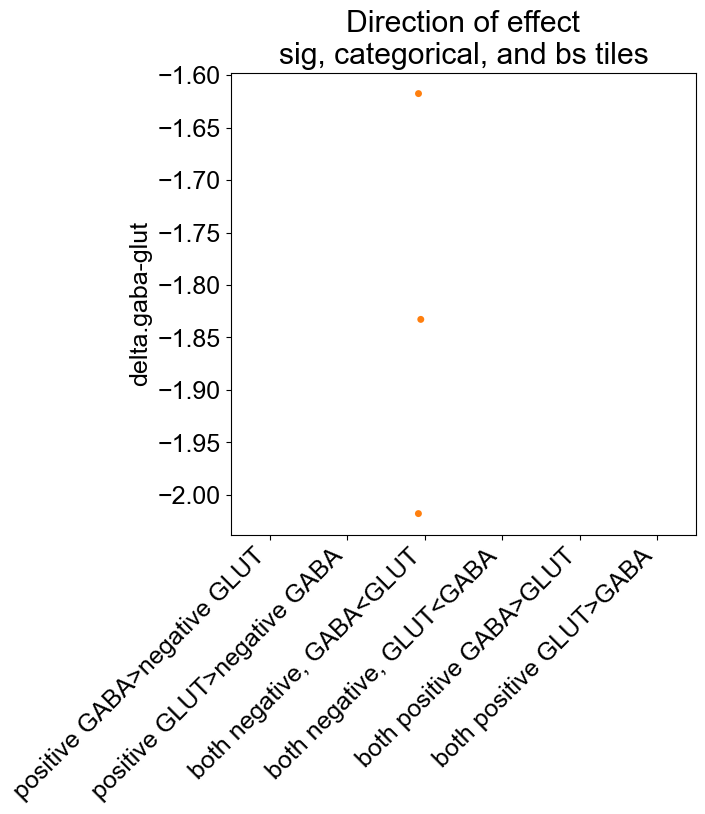

In [53]:
# order
order = ['positive GABA>negative GLUT',
         'positive GLUT>negative GABA',
         'both negative, GABA<GLUT',
         'both negative, GLUT<GABA',
         'both positive GABA>GLUT',
         'both positive GLUT>GABA',
         ]
# plot dataframe
plot_data = enh.loc[
    (enh["sig_n_dif_n_bs"] == True) &
    (enh["bs"] == True), ["direction", "delta.gaba-glut"]].drop_duplicates()

fig, ax = plt.subplots(figsize=(6, 6))

sns.stripplot(x="direction", y="delta.gaba-glut",
              order=order, 
              hue="direction", 
              hue_order=order,
              data=plot_data, 
              palette='tab20'
              )

ax.set(title="Direction of effect\nsig, categorical, and bs tiles", 
      xlabel="")

ax.legend().remove()

ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment="right")
# save
out = os.path.join(RE, f"delta.distribution.direction.syn.pdf")
plt.savefig(out, bbox_inches='tight')

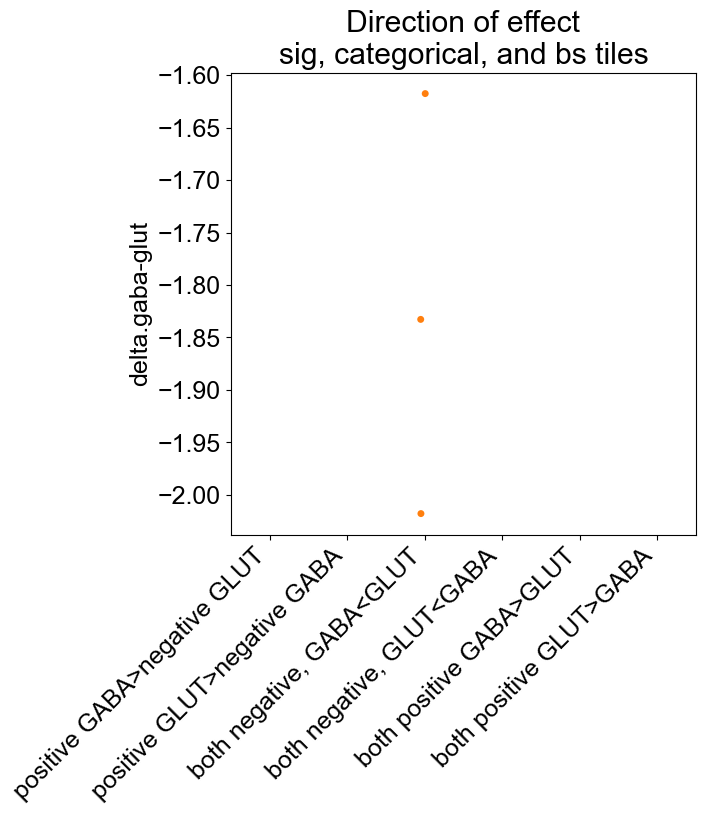

In [74]:
# order
order = ['positive GABA>negative GLUT',
         'positive GLUT>negative GABA',
         'both negative, GABA<GLUT',
         'both negative, GLUT<GABA',
         'both positive GABA>GLUT',
         'both positive GLUT>GABA',
         ]
# plot dataframe
plot_data = enh.loc[
    (enh["sig_n_dif"] == True) &
    (enh["bs"] == True), ["direction", "delta.gaba-glut"]].drop_duplicates()

fig, ax = plt.subplots(figsize=(6, 6))

sns.stripplot(x="direction", y="delta.gaba-glut",
              order=order, 
              hue="direction", 
              hue_order=order,
              data=plot_data, 
              palette='tab20'
              )

ax.set(title="Direction of effect\nsig, categorical, and bs tiles", 
      xlabel="")

ax.legend().remove()

ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
                   horizontalalignment="right")
# save
out = os.path.join(RE, f"delta.distribution.direction.syn.pdf")
plt.savefig(out, bbox_inches='tight')

# data visualization functions

In [54]:
def getMinDist(df):
    """return str of gene, min distance tuples to gene TSSs per enhancer. 
        Gene TSS annotations from GREAT. 
        note - most enhancers map to two genes, which means two TSSs
    """

    genes = []

    # per gene
    for gene in df["gene"].unique():
        genes.append(gene)
        print(gene)

        # get the gene dataframe
        g = df.loc[(df["gene"] == gene)].copy()

        # if upstream TSS, return min value
        g = g.loc[g["dist"] != "NONE"]
        if len(g) > 0:
            if int(g.dist.min()) > 1:
                genes.append(g.dist.min())

            # elif downstream TSS, return max negative value (min)
            elif int(g.dist.min()) < 1:
                genes.append(g.dist.max())
                
            elif list(set(g.dist)) == "na":
                print(gene,  "TO REMOVE")
                genes = genes[:-1]  # remove gene from list, no distance

    if len(genes) == 0:  # handle cases where no gene is mapped to element.
        genes = ["None"]

    new_genes = []

    for gene in genes:
        new_genes.append(str(gene))

    return "_".join(new_genes)

# nominate candidates

## functions!

In [55]:
def getSupport(enh_id, df):
    """count how many supports there is for differential activity"""
    
    # columns to keep
    t_cols = ["name", 'tile.order', "enh.id", "sig", "celltype_dif", "bs"]
    
    # subset df to enh_id w cols, drop duplicates, copy, and fill na w False
    t = df.loc[df["enh.id"] == enh_id, t_cols].drop_duplicates().copy().fillna(False)
    
    # turn bool into int, into str
    t[t_cols[-3:]]=t[t_cols[-3:]].astype(int)
    
    # str code the support col
    t["support"] =  t["sig"] + t["celltype_dif"] + t["bs"]
    
    # turn int into str
    t[t_cols[-3:]]=t[t_cols[-3:]].astype(str)

    t["support_code"] =  t["sig"] + t["celltype_dif"] + t["bs"]    
    
    t["support_name"] = None
    
    # name codes, so that they are legible
    name_codes = {None:"000", 
                  "cat-only":"010", 
                  "sig-only":"100", 
                  "bs-only":'001',
                  "sig-n-cat":"110", 
                  "sig-n-bs":"101", 
                  "cat-n-bs":"011", 
                  "all": "111"
                 }
    
    for name, code in name_codes.items():
        t.loc[t["support_code"]==code, "support_name"] = name


    return t[["name", "tile.order", "support", "support_code", "support_name"
             ]]

In [56]:
def getSigTileIdDirection(direction, df):
    """return tile ids in direction which 
    (1) have significant activity differences
    (2) have categorical activity differences
    (3) exceed the bootstrapped 95 CIs from delta distribution
    """

    cols = ["bs", 'sig_n_dif_n_bs',
            'direction',
            "name"]

    test = df.loc[(df["bs"] == True) &
                  (df["sig_n_dif_n_bs"] == True),
                  cols].drop_duplicates().copy()

    candidate_set = set(test.loc[test["direction"] == direction, "name"])

    return candidate_set

In [57]:
def getLongFormEnhInfo(df, mpra_celltype):
    """ return dataframes for plotting gaba/glut longform tile activity and significance
    """
    # do some data formatting, sorting`
    df["tile.order"] = df["tile.order"].astype(int)
    df = df.sort_values(by="tile.order")

    # get dataframe of tile.order x significant differences
    sd = pd.melt(df, id_vars="tile.order",
                 value_vars="sig_n_dif_n_bs",
                 value_name="sig"
                 ).drop_duplicates().reset_index()
    sd["y"] = 3
    sd["sig"] = sd["sig"].replace(False, None)
    
    # new variable
    VAR_NAME = "Mean z-score ratio"

    # get replicates of gaba, glut and melt into longform
    if mpra_celltype == "gaba": 
        cols = ["gaba_1", "gaba_2", "gaba_3"]
        
    elif mpra_celltype =="glut":
        cols = ["glut_1", "glut_2", "glut_3"]

    # longform GABA
    longform = pd.melt(df, id_vars="tile.order",
                            value_vars=cols,
                            value_name=VAR_NAME).drop_duplicates().reset_index()

   
    # add back significance column
    longform = pd.merge(longform, sd, how="left", left_on="tile.order",
                             right_on='tile.order').drop(columns=["index_x", "index_y"])
    

    # add back missing tiles
    longform = addMissingTiles(longform, VAR_NAME)
    
    # change tile.order datatype
    longform["tile.order"]= longform["tile.order"].astype(int)
    
    # fill any missing data w zeros
    longform[VAR_NAME]=longform[VAR_NAME].fillna(0)
    
    return longform, VAR_NAME

In [58]:
def getEnhid(tile_coor, df):
    """return enhancer coordinate for tile_id"""
    enh = set(df.loc[df["coor"] == tile_coor, 'enh.id'])

    if len(enh) > 1:
        print("more than one enh_id", enh)

    # return the first (and hopefully only) enh
    return list(enh)[0]

In [59]:
def addMissingTiles(longform, var_name):
    """add back missing tile values for a dataframe"""

    # make an empty dataframe
    empty = pd.DataFrame(
        np.arange(longform["tile.order"].min(),
                  longform["tile.order"].max()+1),
        columns=["tile.order"]
    )
    # add back empty, drop old index
    longform = pd.merge(empty, longform,
                             how="left")
    # fill na
    longform[var_name] = longform[var_name].fillna(0)

    return longform

In [60]:
def plotTile(tile_coor, df, direction, plot_support_annot):

    # get enh_id for tile coordinate
    enh_id = getEnhid(tile_coor, df)

    cols = ["sig_n_dif_n_bs", "glut_1", "glut_2", "glut_3", "gaba_1",
            "gaba_2", "gaba_3", "coor", "enh.id", "enh.name", "tile.order", "gene"]

    t = df.loc[df["enh.id"] == enh_id].drop_duplicates().copy()

    # stratify by gene name, as one enhancer may be near two different genes
    enh_name = list(set(t["enh.name"]))[0]
    gene = getMinDist(t)

    # get support for tiles in enhancer
    support = getSupport(enh_id, t)

    t = t[cols[:-1]]  # subset the dataframe to just these columns

    # make an output file name for tile plot.
    out_line = os.path.join(RE_MAPS, direction,
                            f"{gene}.{enh_name}.line.{plot_support_annot}.pdf")

    # if the outpath does not exist, make it
    if os.path.exists(os.path.join(RE_MAPS, direction)) is False:
        os.mkdir(os.path.join(RE_MAPS, direction))

    # plot line
    longform_gaba, longform_glut, var_name = plot_lineplot(
        t, out_line, enh_id,  enh_name, gene, support, plot_support_annot)

    return t, support, longform_gaba, longform_glut, var_name

## That one GABA silent, glut_act

In [72]:
direction

' both negative, GABA<GLUT'

In [73]:
ACTIVE_CL = "GABA"
INACTIVE_CL = "GLUT"
direction = f"positive {ACTIVE_CL}>negative {INACTIVE_CL}"
direction = f"both negative, {ACTIVE_CL}<{INACTIVE_CL}"

# get significant tiles that fall in direction
SET = getSigTileIdDirection(direction, enh)

# subset dataframe and sort
candidate_cols = ["name", ACTIVE_CL.lower(), 'delta.gaba-glut']

# order candidates by highest activity, greatest difference
GABA_candidates = enh.loc[enh["name"].isin(SET), candidate_cols].drop_duplicates().sort_values(
    by=[ACTIVE_CL.lower(), 'delta.gaba-glut'], ascending=False)["name"].to_list()
GABA_candidates

['Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Motiffamily:glutmotif2,Motiffamily:glutmotif2|Motif1:TTCATCATGTGT|Motif2:AAACACATAAGG',
 'Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Motiffamily:glutmotif2,Motiffamily:glutmotif2|Motif1:AAACACATAAGG|Motif2:TCAGTTCTTAAA',
 'Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Motiffamily:glutmotif1,Motiffamily:glutmotif2|Motif1:TGAACTGATACA|Motif2:TTCATTATGTGT']

## Top 8 glutamatergic candidates

In [69]:
ACTIVE_CL = "GLUT"
INACTIVE_CL = "GABA"
direction = f"positive {ACTIVE_CL}>negative {INACTIVE_CL}"

# get significant tiles that fall in direction
SET = getSigTileIdDirection(direction, enh)

# subset dataframe and sort
candidate_cols = ["name", ACTIVE_CL.lower(), 'delta.gaba-glut', "tile.order"]

# order candidates by highest activity, greatest difference
GLUT_candidates = enh.loc[enh["name"].isin(SET), candidate_cols].drop_duplicates().sort_values(
    by=[ACTIVE_CL.lower(), 'delta.gaba-glut'], ascending=False)["name"].to_list()

print(len(GLUT_candidates))
GLUT_candidates[:10]

0


[]